In [1]:
# File Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

# Import ISLP-Specific Functions/Classes
from ISLP.models import(
    ModelSpec as MS,
    summarize
)

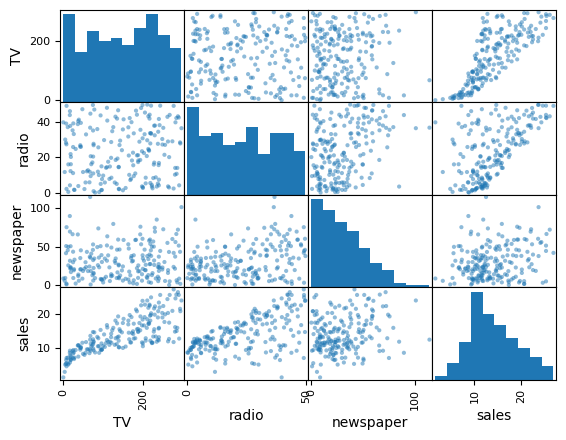

In [2]:
# Read the advertising budget data (Data from An Introduction to Statistical Learning - Springer)
# sales (thousands of units) for a proticular product
# TV (thousands of dollars) - TV advertising budget
# radio (thousands of dollars) - radio advertising budget
# newspaper (thousands of dollars) - newspaper advertsing budget
Advertising = pd.read_csv("data/Advertising.csv")
Advertising.drop('idx', axis=1, inplace=True)

# Create a scatter matrix of the data
pd.plotting.scatter_matrix(Advertising, diagonal='hist')
plt.show()

### 1. Is there a relationship between sales and the advertising budget?
To solve this question, we fit a multiple linear regression model of sales onto TV, radio and newspaper and test whether B_TV = B_radio = B_newspaper = 0. This hypothesis test uses the F-statistic's p-value.

In [3]:
# Create the predictor and response data sets
X = MS(['TV', 'radio', 'newspaper']).fit_transform(Advertising)
y = Advertising['sales']

linear_model = sm.OLS(y, X)
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           1.58e-96
Time:                        07:11:46   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9389      0.312      9.422      0.0

As seen in the OLS regression results, the F-statistic for the fitted linear model is high (570.3). Becasue the F-statistic's p-value is very low, we reject the null hypothesis and conclude that there is a relationship between sales and the advertsing budget.

### 2. How stong is the relationship between the predictors and the response?
To anser this question, we can observe the R squared and further compute the RSE (residual standard error).

OLS Regression R Squared: 0.8972106381789521
OLS Residual Standard Error: 1.6769760888385674
Percentage Error: 11.959180523006363% | mean response: 14.0225


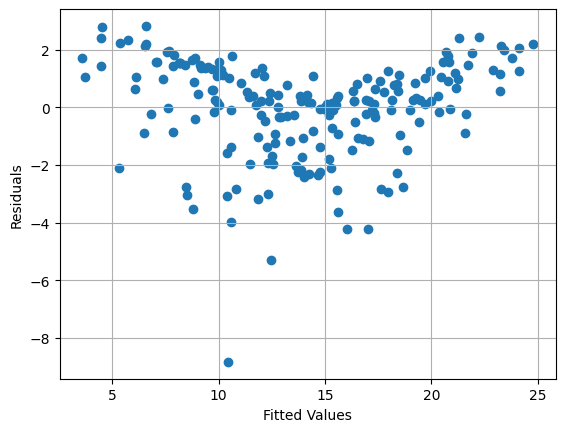

In [4]:
RSS = sum((y - results.fittedvalues) ** 2)
RSE = np.sqrt((1 / (len(y) - 2)) * RSS)

mean_response = sum(y) / len(y)
pct_error = (RSE / mean_response) * 100

print(f'OLS Regression R Squared: {results.rsquared}')
print(f'OLS Residual Standard Error: {RSE}')
print(f'Percentage Error: {pct_error}% | mean response: {mean_response}')

# Plot the residuals
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

RSE (residual standard error) estimates the standard deviation of the response from the population regression line. The RSE is 1.68 units and the mean value of the response is 14.022 indicating a percentage error of approximately 12%. The R squared statistic records the amount of variance in the response that can be explained by the predictors. The model suggests that 89.7% of the variance in sales is captured by the advertising budget.

### 3. Which advertising media are associated with sales?
This question requres us to observe each media's t-statistic p-value. TV and radio have small p-values and newspaper has a large p-value, indicating that TV and radio are associated with sales.

### 4. How large is the association with each advertising media and sales?
The 95% confidence intervals for each advertising budget's coefficients are as follows:<br>
TV = (0.043, 0.049)<br>
radio = (0.172, 0.206)<br>
newspaper = (-0.013, 0.011)<br>
We can see that the confidence interval for newspaper is wide. We can compute the VIFs (variance inflation factors) for each of the predictors to see if the wide confidence interval is due to collinearity.

In [5]:
vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif' : vifs}, index=X.columns[1:])
print(vif)

                vif
TV         1.004611
radio      1.144952
newspaper  1.145187


The above VIFs suggest that there is no collinearity among predictors. To determine the strength of each advertising media on sales, we can conduct individual regressions.

In [6]:
# 1. sales onto TV
X = MS(['TV']).fit_transform(Advertising)
tv_model = sm.OLS(y, X)
tv_results = tv_model.fit()
print("TV OLS Model:")
print(summarize(tv_results))

# 2. sales onto radio
X = MS(['radio']).fit_transform(Advertising)
radio_model = sm.OLS(y, X)
radio_results = radio_model.fit()
print("\nRadio OLS Model:")
print(summarize(radio_results))

# 3. sales onto newspaper
X = MS(['newspaper']).fit_transform(Advertising)
newspaper_model = sm.OLS(y, X)
newspaper_results = newspaper_model.fit()
print("\nNewspaper OLS Model:")
print(summarize(newspaper_results))

TV OLS Model:
             coef  std err       t  P>|t|
intercept  7.0326    0.458  15.360    0.0
TV         0.0475    0.003  17.668    0.0

Radio OLS Model:
             coef  std err       t  P>|t|
intercept  9.3116    0.563  16.542    0.0
radio      0.2025    0.020   9.921    0.0

Newspaper OLS Model:
              coef  std err       t  P>|t|
intercept  12.3514    0.621  19.876  0.000
newspaper   0.0547    0.017   3.300  0.001


TV and radio have very small p-values, suggesting a strong relationship with sales. The newspaper p-value suggests a mild association with sales.

### 5. How accurately can we predict future sales?
See the regression summary above for an in-sample prediction summary.

### 6. Is the relationship between the predictors and response linear?
Viewing the residual vs fitted values plot, we can see that there is an indication of a non-linear relationship between the predictors and the response.

### 7. Is there synergy between the advertising media?
To measure the potential synergy between the different advertising media, we can include interaction terms in the linear regression model. By observing the p-value of the interaction terms, we can determine if a synergy exists. Because we have previously concluded that TV and radio are statistically significany predictors, we will measure the synergy between them.

In [7]:
# Checking the synergy between TV and radio
X = MS(['TV', 'radio']).fit_transform(Advertising)
X['tv_ratio'] = X['TV'] * X['radio']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Mon, 14 Apr 2025   Prob (F-statistic):          6.68e-146
Time:                        07:11:46   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7502      0.248     27.233      0.0

The tv_radio predictor is TV * radio, which is an interaction between the two individual predictors. We can interpret the tv_radio coefficient (0.0011) as the increase in effectiveness of TV advertising associated with a one unit increase of radio advertising. The p-value for the interaction term, suggesting that there is a non-additive relationship. The model with the interaction term is superior to the model only containing the main effects.